In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


This notebook is simply to represent some of the functions of QuasarNP, a pure numpy (and h5py for loading) implementation of QuasarNet.

First let's load some data to test on. These first few cells are ripped straight from the QuasarNet tutorial notebook.

In [2]:
# QuasarNET imports
from quasarnet.models import QuasarNET, custom_loss

# Importing utility functions from QuasarNP
from quasarnp.io import read_truth, read_data, wave
from quasarnp.utils import process_preds, absorber_IGM

from tensorflow.keras.models import load_model

import fitsio

In [3]:
lines = ['LYA','CIV(1548)','CIII(1909)', 'MgII(2796)','Hbeta','Halpha']
lines_bal = ['CIV(1548)']

In [4]:
# set nspec to the number of spectra to load. 30000 should be plenty!
nspec = 30000
truth_file=(['/global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/truth_DR12Q.fits'])
truth = read_truth(truth_file)
tids_full,X_full,Y_full,z_full,bal_full = read_data(['/global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_dr12.fits'], truth, nspec=nspec)

# Load the training data.
data_file = '/global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_train_0.fits'
h = fitsio.FITS(data_file)
tids_train = h[1]['TARGETID'][:]
w = np.in1d(tids_full, tids_train)
X_train = X_full[w]
Y_train = Y_full[w]
z_train = z_full[w]
bal_train = bal_full[w]

# To get the validation data, remove the spectra in the training sample from the full sample
w = ~np.in1d(tids_full, tids_train)
tids_val = tids_full[w]
X_val = X_full[w]
Y_val = Y_full[w]
z_val = z_full[w]
bal_val = bal_full[w]

INFO: reading data from /global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_dr12.fits
INFO: removing 82 spectra missing in truth
INFO: found (29786,) spectra in file /global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_dr12.fits
INFO: removing 40 spectra with zero weights
INFO: removing 0 spectra with zero flux


Generally speaking we will be using QuasarNet with pretrained weights. In order to load the model weights we simply run Keras' `load_model` function.

In [5]:
model_tf = load_model("weights/qn_train_1.h5", compile=False)
p_tf = model_tf.predict(X_val[:,:,None])

QuasarNP is designed to be easily integrable into previous code. For example, loading a model in QuasarNP is the same as when you load QuasarNet, but instead of using the Keras `load_model` you use the QuasarNP implentation. To avoid function clobbering I have renamed it in this import.

In [6]:
from quasarnp.io import load_model as load_model_np

model_np = load_model_np("weights/qn_train_1.h5")
p_np = model_np.predict(X_val[:,:,None])

/global/u2/d/dylang/QuasarNET/quasarnp/layers.py:9: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda x: 1 / (1 + np.exp(-x))


We can verify that the numpy implementation is close to the tensorflow one very easily. Let's simply find the maximum absolute difference between the two implementations for each of the 7 lines. This will give a measure of how close the two are. 

In [7]:
for i, _ in enumerate(p_np):
    print(np.max(np.abs(p_np[i] - p_tf[i])))

3.3845630720841235e-06
4.183399264445775e-06
4.161150034098782e-06
6.264914925391274e-06
3.5833598961976243e-06
7.809056028262873e-06
5.5167863021177155e-06


In [8]:
np.max(np.abs(np.asarray(p_np) - np.asarray(p_tf)))

7.809056028262873e-06

1e-5 is pretty close and is largely attributed to floating point math differences between tensorflow and numpy. What really matters is that the actual line identification from each of these two implementations is the same, so let's confirm that.

Due to the increased precision of numpy we will have problems identifying the redshift of the line, due largley to an argmax in the process_preds() function. This does not affect the confidence of which box the line appears in, and therefore does not change the identificaion of whether something is a QSO or not. 

In [9]:
pred_output_tf = process_preds(p_tf, lines, lines_bal)
pred_output_np = process_preds(p_np, lines, lines_bal)

INFO: nspec = 2412, nboxes=13
INFO: nspec = 2412, nboxes=13


In [10]:
for i in range(len(pred_output_tf)):
    print(np.max(np.abs(pred_output_tf[i] - pred_output_np[i])))

7.809056028262873e-06
5.123412048204455
5.083694411488736
5.5167863021177155e-06
3.9627155439551185


In order to confirm that our predictions of QSOs are correct or at least "correct enough" we will find the purity and completeness of the two implementations and confirm that they are similar (or even better, identical).

We will use the same metric as the paper/tutorial notebook:

 - Purity (precision) $= \frac{\mathrm{number\ of\ correctly\ classified\ QSOs}}{\mathrm{number\ of\ objects\ classified\ as\ QSOs}}$
 
 - Completeness (recall) $= \frac{\mathrm{number\ of\ correctly\ classified\ QSOs}}{\mathrm{number\ of\ true\ QSOs}}$
 
Here, we count a QSO as being "correctly classified" if QuasarNET is both able to identify it as a QSO, and correctly estimate its redshift to within a velocity error of 6,000 km/s.

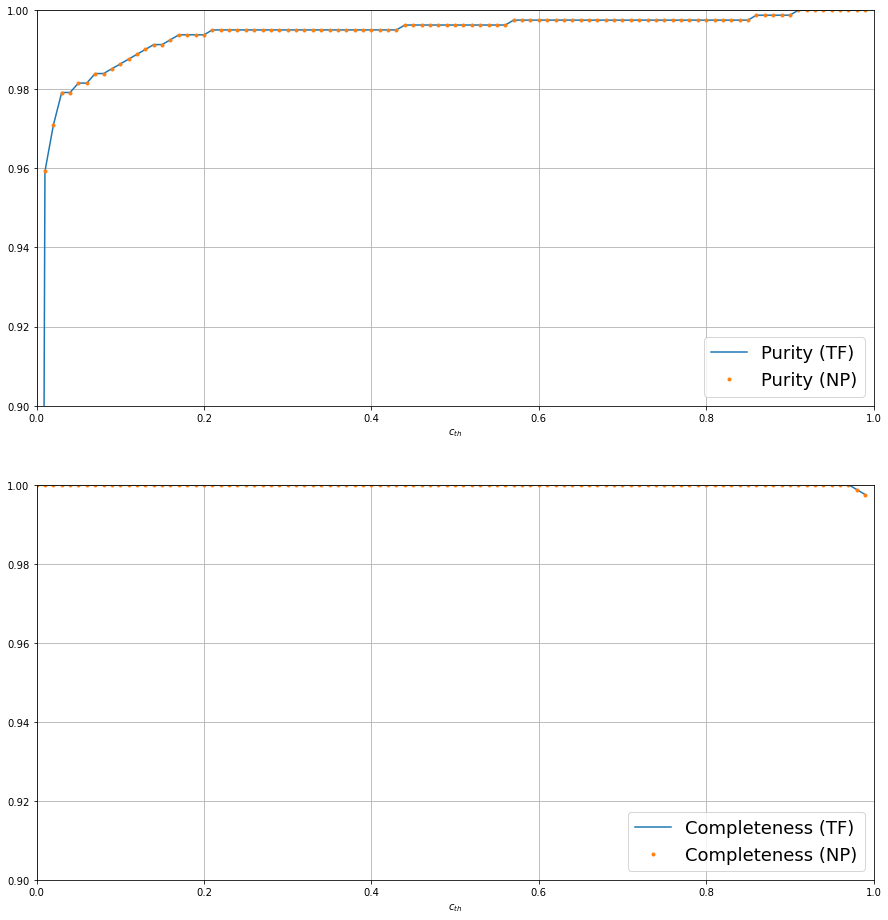

In [11]:
c_line_tf, _, zbest_tf, *rest = pred_output_tf
c_line_np, _, zbest_np, *rest = pred_output_np
ndetect = 1

fig, ax = plt.subplots(2, 1, figsize=(15, 16))
plt.rc('font', size=18)

# Set up our arrays.
c_thresh = np.arange(0,1,0.01)

# Purity
pur_np = np.zeros_like(c_thresh)
pur_tf = np.zeros_like(c_thresh)

# Completeness
com_np = np.zeros_like(c_thresh)
com_tf = np.zeros_like(c_thresh)

# Error for zmax computations
dv_max = 6000./300000.

# Determine which objects are true QSOs, and which are "bad"
isqso_truth = (Y_val.argmax(axis=1) == 2) | (Y_val.argmax(axis=1) == 3)
is_bad = Y_val.argmax(axis=1) == 4

# Determine which spectra QN accurately estimated the redshift for
zgood_tf = (z_val > 0) & (abs(zbest_tf - z_val) < dv_max * (1 + z_val))
zgood_np = (z_val > 0) & (abs(zbest_np - z_val) < dv_max * (1 + z_val))


# For each value of confidence threshold, compute purity and completeness.
for i,cth in enumerate(c_thresh):
    # Tensorflow
    isqso_qn = (c_line_tf > cth).sum(axis=0) >= ndetect
    ntrue_positives = (isqso_qn & zgood_tf & ~is_bad).sum()
    pur_tf[i] = ntrue_positives/(isqso_qn & (~is_bad)).sum()
    com_tf[i] = (isqso_qn & zgood_tf & isqso_truth).sum()/isqso_truth.sum()
    
    # Numpy
    isqso_qn = (c_line_np > cth).sum(axis=0) >= ndetect
    ntrue_positives = (isqso_qn & zgood_np & ~is_bad).sum()
    pur_np[i] = ntrue_positives/(isqso_qn & (~is_bad)).sum()
    com_np[i] = (isqso_qn & zgood_np & isqso_truth).sum()/isqso_truth.sum()
    
# Plot them!
ax[0].plot(c_thresh, pur_tf, label="Purity (TF)")
ax[0].plot(c_thresh, pur_np, ".", label="Purity (NP)")
ax[0].set_xlim(0.0,1.0)
ax[0].set_ylim(0.9,1.0)
ax[0].set_xlabel(r'$c_{th}$')
ax[0].grid()
ax[0].legend(loc=4)

ax[1].plot(c_thresh, com_tf, label="Completeness (TF)")
ax[1].plot(c_thresh, com_np, ".", label="Completeness (NP)")
ax[1].set_xlim(0.0,1.0)
ax[1].set_ylim(0.9,1.0)
ax[1].set_xlabel(r'$c_{th}$')
ax[1].grid()
ax[1].legend(loc=4)

Neat!